# Quantum Signal Processing
### The building blocks of quantum algorithms

### Welcome!  

In this notebook, we will walk you through how to design your own *quantum signal processing* protocol. We start by importing the necessary packages.


In [19]:
from qiskit_ibm_runtime import QiskitRuntimeService

lcl_token = "INPUT TOKEN"

service = QiskitRuntimeService(
    channel="ibm_quantum", instance="ibm-q/open/main", token=lcl_token
)

In [133]:
import json

We can now list out all the backends that are available on the IBM processor.

In [20]:
service.backends()

[<IBMBackend('simulator_mps')>,
 <IBMBackend('simulator_statevector')>,
 <IBMBackend('simulator_stabilizer')>,
 <IBMBackend('ibm_brisbane')>,
 <IBMBackend('ibm_kyoto')>,
 <IBMBackend('ibm_osaka')>,
 <IBMBackend('ibmq_qasm_simulator')>,
 <IBMBackend('simulator_extended_stabilizer')>]

For this project, we are using both a simulator and an actual backend, but you can replace this with any simulator or quantum computer of your choice.

In [21]:
backend_sim = service.backend("ibmq_qasm_simulator")

In [141]:
backend = service.least_busy(simulator=False, operational=True)
backend

<IBMBackend('ibm_kyoto')>

Let's start with our circuit! Important steps will be included as comments throughout the code. We will be walking you through how to use PSQ to better approximate a sine function, but this procedure can be used to generate a polynomial approximation of anything that you'd like. 

Importantly, the key to PSQ working is the sequence of phase angles $\vec{\phi}$. The procedure for generating these angles is computationally complex—and involves Remez-type exchange algorithms—but there are excellent python packages to determine these for us. 

We used the following code to generate sequences:
```
pysqsp --plot-real-only --plot-npts={n} --seqargs=[4,0.1] --plot hamsim
```

where {n} is determined by the user. Note that higher values of n will perform better classically and worse on a quantum computer, so perhaps there is a method to determine the equilibrium value...


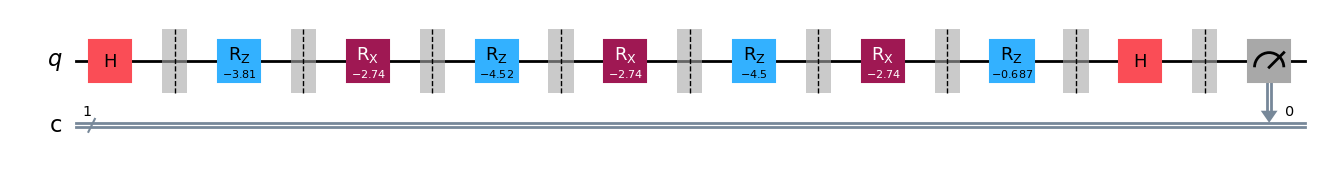

In [82]:
from qiskit import QuantumCircuit
import numpy as np

qc = QuantumCircuit(1,1)

# 2x

phi_3 = [0.3434281, 2.249998, 2.2590873, 1.9060472] ## our arbitrary phase tuple, generated as described above
phi_3.reverse()

a = 0.2

qc.h(0)

qc.barrier(0)

# Applies the equation described on the website in Qiskit
for i in range(len(phi_3)):
    if(i != 0):
        qc.rx(-2*np.arccos(a),0)
        qc.barrier(0)
    qc.rz(-2*phi_3[i], 0)
    qc.barrier(0)

qc.h(0)

qc.barrier(0)

# Measures all the qubits
qc.measure([0], [0])

qc.draw(output="mpl", style="iqp")

With this accomplished, we can now submit our jobs to the quantum computer.

In [83]:
from qiskit_ibm_runtime import Sampler, Options

options = Options()
options.resilience_level = 1
options.optimization_level = 3

# Create an Estimator object
sampler = Sampler(backend_sim, options=options)

# Submit the circuit to Estimator
job = sampler.run(qc, shots=1000)

In [85]:
jobid = job.job_id()
print(f">>> Job ID: {job.job_id()}")
print(f">>> Job Status: {job.status()}")

>>> Job ID: cmverc779cpiv1dslse0
>>> Job Status: JobStatus.DONE


Let's retrieve our job and see what it looks like!

In [86]:
retrieve_job = service.job(jobid)
result = retrieve_job.result()

In [88]:
from qiskit.visualization import plot_distribution

plot_distribution(result.quasi_dists[0].binary_probabilities())
print(result)

SamplerResult(quasi_dists=[{0: 0.133, 1: 0.867}], metadata=[{'shots': 1000, 'circuit_metadata': {}, 'readout_mitigation_overhead': 1.0, 'readout_mitigation_time': 0.016960766166448593, 'warning': 'Optimization level clipped from 3 to 1'}])


In [93]:
print(result.quasi_dists[0][0])

0.133


Let us now combine all of our work so far and define some functions to increase modularity.

In [135]:
def gen_qc(a):
    qc = QuantumCircuit(1,1)

    # 2x

    phi_3 = [0.3434281, 2.249998, 2.2590873, 1.9060472]
    phi_3.reverse()

    qc.h(0)

    qc.barrier(0)

    for i in range(len(phi_3)):
        if(i != 0):
            qc.rx(-2*np.arccos(a),0)
            qc.barrier(0)
        qc.rz(-2*phi_3[i], 0)
        qc.barrier(0)

    qc.h(0)

    qc.barrier(0)

    # measure all the qubits
    qc.measure([0], [0])

    qc.draw(output="mpl", style="iqp")
    return qc

def eval_qc(qc):
    # Create an Estimator object
    sampler = Sampler(backend_sim, options=options)

    # Submit the circuit to Estimator
    job = sampler.run(qc, shots=100)
    jobid = job.job_id()
    retrieve_job = service.job(jobid)
    result = retrieve_job.result()
    return result

def eval_qc_list(qc_list):
    # Create an Estimator object
    sampler = Sampler(backend_sim, options=options)

    # Submit the circuit to Estimator
    job = sampler.run([x[1] for x in qc_list], shots=100)
    jobid = job.job_id()
    retrieve_job = service.job(jobid)
    result = retrieve_job.result()
    return result

job_ids = []

qc_list = []

for x in np.linspace(-1, 1, 21):
    qc_lcl = gen_qc(x)
    print(x)
    qc_list.append([x, qc_lcl])

res = eval_qc_list(qc_list)

-1.0
-0.9
-0.8
-0.7
-0.6
-0.5
-0.3999999999999999
-0.29999999999999993
-0.19999999999999996
-0.09999999999999998
0.0
0.10000000000000009
0.20000000000000018
0.30000000000000004
0.40000000000000013
0.5
0.6000000000000001
0.7000000000000002
0.8
0.9000000000000001
1.0


We now compute the values we are interested in. Remember, we are attempting to use QSP to find an accurate approximation of $\sin$. As a result, we will be determining the deviation from $\sin$ from the polynomial that we generated using the QSP protocol. If we have done this correctly, then the lines should match...

In [136]:
x = [u[0] for u in qc_list]
y1 = []
y2 = []
i = 0
for q in res.quasi_dists:
    zero_val = q
    if 0 in zero_val:
        zero_val = zero_val[0]
    else:
        zero_val = 0
    computed_y = np.sqrt(zero_val)
    actual_y = np.sin(2*x[i])
    print(f"For x = {x[i]}, computed y = {computed_y}, actual sin(2x) = {actual_y}")
    y1.append(computed_y)
    y2.append(actual_y)
    i += 1

For x = -1.0, computed y = 0.8944271909999159, actual sin(2x) = -0.9092974268256817
For x = -0.9, computed y = 0.9848857801796105, actual sin(2x) = -0.9738476308781951
For x = -0.8, computed y = 1.0, actual sin(2x) = -0.9995736030415051
For x = -0.7, computed y = 0.9643650760992956, actual sin(2x) = -0.9854497299884601
For x = -0.6, computed y = 0.9273618495495703, actual sin(2x) = -0.9320390859672263
For x = -0.5, computed y = 0.8185352771872451, actual sin(2x) = -0.8414709848078965
For x = -0.3999999999999999, computed y = 0.714142842854285, actual sin(2x) = -0.7173560908995227
For x = -0.29999999999999993, computed y = 0.5477225575051661, actual sin(2x) = -0.5646424733950353
For x = -0.19999999999999996, computed y = 0.33166247903553997, actual sin(2x) = -0.3894183423086504
For x = -0.09999999999999998, computed y = 0.1414213562373095, actual sin(2x) = -0.19866933079506116
For x = 0.0, computed y = 0.0, actual sin(2x) = 0.0
For x = 0.10000000000000009, computed y = 0.173205080756887

Et voilá!

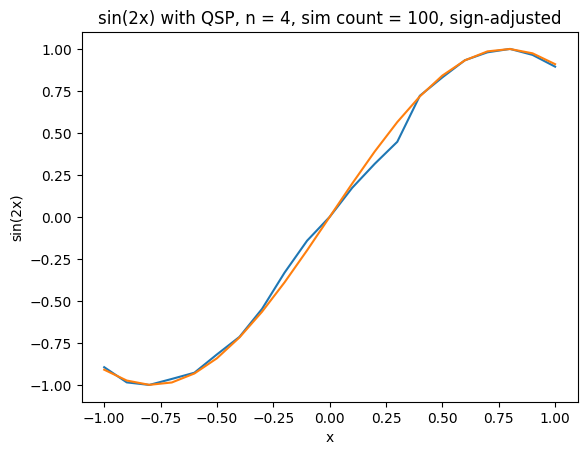

In [140]:
import matplotlib as mpl

mpl.pyplot.plot(x, np.sign(x) * y1)
mpl.pyplot.plot(x, y2)
mpl.pyplot.title("sin(2x) with QSP, n = 4, sim count = 100, sign-adjusted")
mpl.pyplot.xlabel("x")
mpl.pyplot.ylabel("sin(2x)")
mpl.pyplot.savefig("QSP_sim_4.png")

In [139]:
o = {"x": x, "y_sim": y1, "y_actual": y2}
of = open("QSP_sim_4.json", "w")
json.dump(o, of)
of.close()

In [105]:
print(job_ids)

[[-1.0, SamplerResult(quasi_dists=[{0: 0.8, 1: 0.2}], metadata=[{'shots': 100, 'circuit_metadata': {}, 'readout_mitigation_overhead': 1.0, 'readout_mitigation_time': 0.011691818945109844, 'warning': 'Optimization level clipped from 3 to 1'}])], [-0.9, SamplerResult(quasi_dists=[{0: 0.92, 1: 0.08}], metadata=[{'shots': 100, 'circuit_metadata': {}, 'readout_mitigation_overhead': 1.0, 'readout_mitigation_time': 0.02065568696707487, 'warning': 'Optimization level clipped from 3 to 1'}])], [-0.8, SamplerResult(quasi_dists=[{0: 1.0}], metadata=[{'shots': 100, 'circuit_metadata': {}, 'readout_mitigation_overhead': 1.0, 'readout_mitigation_time': 0.006950044073164463, 'warning': 'Optimization level clipped from 3 to 1'}])], [-0.7, SamplerResult(quasi_dists=[{0: 0.94, 1: 0.06}], metadata=[{'shots': 100, 'circuit_metadata': {}, 'readout_mitigation_overhead': 1.0, 'readout_mitigation_time': 0.02080469485372305, 'warning': 'Optimization level clipped from 3 to 1'}])], [-0.6, SamplerResult(quasi_di

We hope that this has been an illustrative journey to show you how to implement a sample QSP protocol on an actual quantum computer. Armed with this information, you can create your own QSPs and develop your own algorithms. (To learn how to use QSPs to assemble more interesting quantum algorithms that have quantum advantage, stay tuned for the next notebook...)

QSPs are a powerful concept in quantum information science that form the foundation of the major developments to come in the future. We invite you to work with these and change tomorrow, today.

____________________________________________________________________________

Work Copyright: Frank Wong, Pranet Sharma, Brennan Lagasse, George Holm, Diya Naik, © 2024 Yale University